# 1. Neural network with keras

In [0]:
import os
from keras import backend as K

K.backend() # check backend of Keras

Using TensorFlow backend.


'tensorflow'

In [0]:
import numpy as np
from datetime import datetime
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense
from keras.utils import np_utils
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
from keras.optimizers import SGD

sns.set() # Draw grid on plot

In [0]:
"""
 That class, Timer checks elasped time for training
"""
class Timer:

  def __init__(self):
    self.start = None
    self.end = None

  def start_timer(self):
    self.start = datetime.now()

  def stop_timer(self):
    self.end = datetime.now()
    return self.end - self.start

In [0]:
def display_dataset(X_train, y_train):  
  fig, ax = plt.subplots(8, 8, figsize = (6, 6))
  fig.suptitle('MNIST')
  fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
  for y, x in [(j, i) for j in range(8) for i in range(8)]:
    idx = np.random.randint(len(y_test))
    ax[y, x].imshow(X_train[idx])
    ax[y, x].set_title(y_train[idx])
    ax[y,x].axis('off')

def display_history(history):
  h = history.history
  fig, ax = plt.subplots(1,2, figsize = (8,4))
  plt.subplots_adjust(wspace = 0.5)
  fig.suptitle('Training result')

  ax[0].set_title('Accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].plot(h['acc'])
  ax[0].plot(h['val_acc'])
  
  ax[1].set_title('Loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].plot(h['loss'])
  ax[1].plot(h['val_loss'])
  fig.legend(['train','validation'])

def visualize_prediction(X_test,y_test,preds):
  fig, ax = plt.subplots(4, 4, figsize = (10, 10))
  plt.subplots_adjust(hspace = 0.8)
  fig.suptitle('Test')

  for y, x in [(j, i) for j in range(4) for i in range(4)]:
    if y == 2 and x == 0 : # display false prediction
      _X_test = X_test[y_test != preds.argmax(-1)]
      _preds = preds[y_test != preds.argmax(-1)]
      _y_test = y_test[y_test != preds.argmax(-1)]

    elif y == 0 and x == 0 : # display true prediction
      _X_test = X_test[y_test == preds.argmax(-1)]
      _preds = preds[y_test == preds.argmax(-1)]
      _y_test = y_test[y_test == preds.argmax(-1)]
      
      
    idx = np.random.randint(len(_y_test))
    ax[y, x].set_title("true : "+str(_y_test[idx])+"\n pred : " + str(_preds[idx].argmax())+"\n"+str(round(_preds[idx].max(),2)))
    ax[y, x].axis('off')
    ax[y, x].imshow(_X_test[idx])

In [0]:
model = None
CLASSES = 10 # Number of labels
HIDDENS = 128 # How many neurons(nodes) in hidden layers
EPOCHS = 20 # train dataset is used "EPOCHS" times
BATCH_SIZE = 128 # How many data in the train dataset are used for update of weights one time
VERBOSE = 2 # How expression for training is printed
VALIDATION_SPLIT = 0.2 # How many data in train dataset are used for validation dataset which is not used for training

"""
 60,000 number of training dataset
 10,000 number of test dataset
 X_train includes 60,000 number of data, 28x28 matrix, to be trained
 y_train includes one vector whose number of elements is 60,000
 X_test includes 10,000 number of data, 28x28 matrix, to be trained
 y_test includes one vector whose number of elements is 10,000
"""
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# look channel, number of data, is first
print('X_train.shape :',X_train.shape,'It means there are 60,000 number of data, 28x28 matrix in train dataset')
print('X_test.shape :',X_test.shape,' It means there are 10,000 number of data, 28x28 matrix in test dataset')

X_train.shape : (60000, 28, 28) It means there are 60,000 number of data, 28x28 matrix in train dataset
X_test.shape : (10000, 28, 28)  It means there are 10,000 number of data, 28x28 matrix in test dataset


In [0]:
print('y_train.shape :',y_train.shape,'It means that y_train includes one vector whose number of elements is 60,000')
print('y_test,shape :',y_test.shape,'It means that y_test includes one vector whose number of elements is 10,000')

y_train.shape : (60000,) It means that y_train includes one vector whose number of elements is 60,000
y_test,shape : (10000,) It means that y_test includes one vector whose number of elements is 10,000


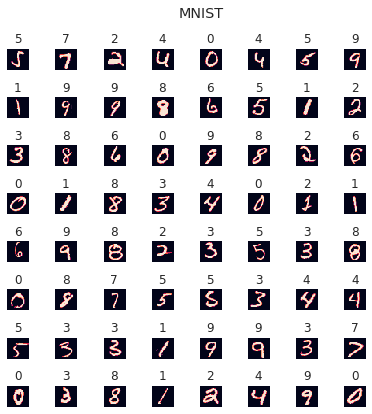

In [0]:
# Visualize dataset
display_dataset(X_train, y_train)

In [0]:
"""
 Every image, 28x28 matrix, for train dataset and test dataset has to be converted into vector to be entered.
 As a result, X_train and X_test become 60,000x784 matrix and 10,000x784 matrix that size of each row means number of data 
and size of each column means number of features, 28*28=784.
 Before being entered into the model, they have to be normalized. 
"""
X_train = X_train.reshape(60000,784).astype('float32')
X_test = X_test.reshape(10000,784).astype('float32')

# Divide each feature by 255, maximum value of brightness, to normalize those data
X_train /= 255
X_test /= 255

"""
 Following is one-hot-encoding.
 As I mentioned, the vector has 60,000 number of elements in y_train 
and 10,000 number of elements in y_test.
 One-hot encoding makes the vector a matrix that size of each row means number of data and size of each column means number of labels.
 Each label is re-written in label-th element as 1 and the others as 0
(e.g. 4 -> [0,0,0,0,1,0,0,0,0,0], remember label is one of 0 ~ 9) 
"""
Y_train = np_utils.to_categorical(y_train, CLASSES)
Y_test = np_utils.to_categorical(y_test, CLASSES)
print('Y_train.shape :',Y_train.shape)
print('Y_test.shape :',Y_test.shape)

Y_train.shape : (60000, 10)
Y_test.shape : (10000, 10)


In [0]:
"""
 Following code is single layer perceptron.
 That class, Dense() means fully connected layer.
 As a result, number of parameters is that 784*10(weights) + 10(biases) = 7850.
 If you run that code, then you see Output Shape is (None, 10). None means batch size, you will define in the method, fit().
and 10 means number of labels 
 A row of Output Shape is None that batch size which will be defined by user later.
"""
if model != None:
  K.clear_session()
model = Sequential()
model.add(Dense(CLASSES, input_shape = (784,),activation = 'softmax'))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])
timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 48000 samples, validate on 12000 samples
Epoch 1/20





 - 1s - loss: 1.3749 - acc: 0.6773 - val_loss: 0.8943 - val_acc: 0.8297
Epoch 2/20
 - 1s - loss: 0.7899 - acc: 0.8321 - val_loss: 0.6575 - val_acc: 0.8568
Epoch 3/20
 - 1s - loss: 0.6410 - acc: 0.8527 - val_loss: 0.5620 - val_acc: 0.8692
Epoch 4/20
 - 1s - loss: 0.5691 - acc: 0.8640 - val_loss: 0.5090 - val_acc: 0.8764
Epoch 5/20
 - 1s - loss: 0.5254 - acc: 0.8701 - val_loss: 0.4750 - val_acc: 0.8822
Epoch 6/20
 - 1s - loss: 0.4954 - acc: 0.8747 - val_loss: 0.4509 - val_acc: 0.8875
Epoch 7/20
 - 1s - loss: 0.4732 - acc: 0.8789 - val_loss: 0.4324 - val_acc: 0.8916
Epoch 8/20
 - 1s - loss: 0.4559 - acc: 0.8820 - val_loss: 0.4184 - val_acc: 0.8932
Epoch 9/20
 - 1s - loss: 0.4420 - acc: 0.8844 - val_loss: 0.4068 - val_acc: 0.8955
Epoch 10/20
 - 1s - loss: 0.4305 - acc: 0.8868 - val_loss: 0.3972 - val_acc: 0.8969
Epoch 11/20
 - 

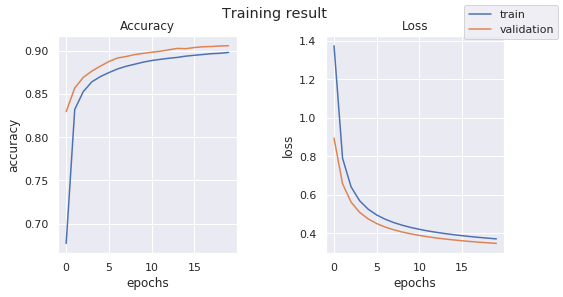

In [0]:
display_history(history)

In [0]:
_, accuracy = model.evaluate(X_test, Y_test)
print('Accuracy :',accuracy)

10000/10000 [==============================] - 0s 24us/step
Accuracy : 0.9065


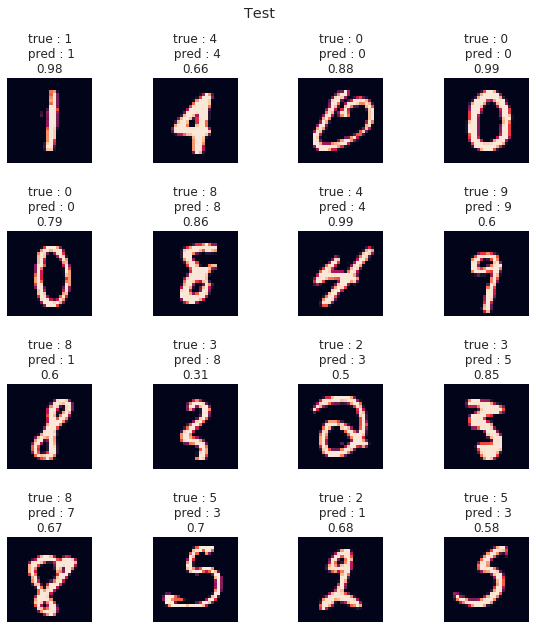

In [0]:
preds = model.predict(X_test)
visualize_prediction(X_test.reshape(10000,28,28),y_test,preds)

## MLP
- 2 layers
- 3 layers
- 4 layers
- 20 layers

In [0]:
"""
 That method describes how many layers are created, using that parameter, layers.
 The number of neurons is same in all layers, except for last layer.
"""
def create_mlp(layers):
  model = Sequential()
  model.add(Dense(HIDDENS, input_shape = (784,), activation = 'relu'))
  if layers > 2:
    for i in range(layers - 2):
      model.add(Dense(HIDDENS, activation = 'relu'))
  model.add(Dense(CLASSES, activation = 'softmax'))
  return model

In [0]:
if model != None:
  K.clear_session()
model = create_mlp(2)
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 1.3075 - acc: 0.6893 - val_loss: 0.7356 - val_acc: 0.8462
Epoch 2/20
 - 2s - loss: 0.6266 - acc: 0.8524 - val_loss: 0.4976 - val_acc: 0.8808
Epoch 3/20
 - 1s - loss: 0.4865 - acc: 0.8746 - val_loss: 0.4185 - val_acc: 0.8937
Epoch 4/20
 - 2s - loss: 0.4260 - acc: 0.8865 - val_loss: 0.3768 - val_acc: 0.8997
Epoch 5/20
 - 1s - loss: 0.3908 - acc: 0.8931 - val_loss: 0.3514 - val_acc: 0.9039
Epoch 6/20
 - 1s - loss: 0.3669 - acc: 0.8991 - val_loss: 0.3335 - val_acc: 0.9079
Epoch 7/20
 - 1s - loss: 0.3491 - acc: 0.9032 - val_loss: 0.3208 - val_acc: 0.9110
Epoch 8/20
 - 1s - loss: 0.3351 - acc: 0.9067 - val_loss: 0.3087 - val_acc: 0.9136
Epoch 9/20
 - 2s - loss: 0.3232 - acc: 0.9098 - val_loss: 0.3009 - val_acc: 0.9157
Epoch 10/20
 - 2s - loss: 0.3132 - acc: 0.9118 - val_loss: 0.2916 - val_acc: 0.9187
Epoch 11/20
 - 2s - loss: 0.3043 - acc: 0.9147 - val_loss: 0.2850 - val_acc: 0.9197
Epoch 12/20
 - 1s - loss: 0.2963 - 

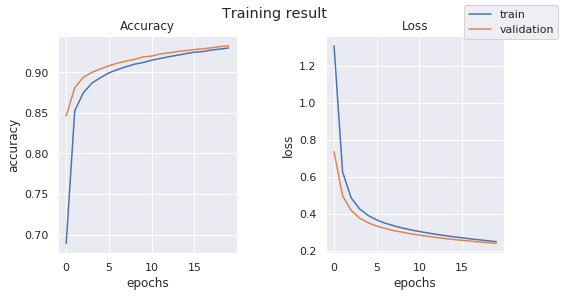

In [0]:
display_history(history = history)

In [0]:
_, accuracy = model.evaluate(X_test, Y_test)
print('Accuracy :',accuracy)

10000/10000 [==============================] - 0s 27us/step
Accuracy : 0.9332


In [0]:
if model != None:
  K.clear_session()
model = create_mlp(3)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 1.3835 - acc: 0.6536 - val_loss: 0.6886 - val_acc: 0.8438
Epoch 2/20
 - 2s - loss: 0.5652 - acc: 0.8575 - val_loss: 0.4339 - val_acc: 0.8864
Epoch 3/20
 - 2s - loss: 0.4232 - acc: 0.8853 - val_loss: 0.3626 - val_acc: 0.8999
Epoch 4/20
 - 2s - loss: 0.3682 - acc: 0.8970 - val_loss: 0.3280 - val_acc: 0.9080
Epoch 5/20
 - 2s - loss: 0.3364 - acc: 0.9055 - val_loss: 0.3033 - val_acc: 0.9135
Epoch 6/20
 - 2s - loss: 0.3140 - acc: 0.9105 - val_loss: 0.2886 - val_acc: 0.9183
Epoch 7/20
 - 2s - loss: 0.2964 - acc: 0.9157 - val_loss: 0.2722 - val_acc: 0.9214
Epoch 8/20
 - 2s - loss: 0.2817 - acc: 0.9198 - val_loss: 0.2622 - val_acc: 0.9260
Epoch 9/20
 - 2s - loss: 0.2689 - acc: 0.9232 - val_loss: 0.2516 - val_acc: 0.9282
Epoch 10/20
 - 2s - loss: 0.2580 - acc: 0.9269 - val_loss: 0.2415 - val_acc: 0.9301
Epoch 11/20
 - 2s - loss: 0.2479 - acc: 0.9296 - val_loss: 0.2341 - val_acc: 0.9321
Epoch 12/20
 - 2s - loss: 0.2387 - 

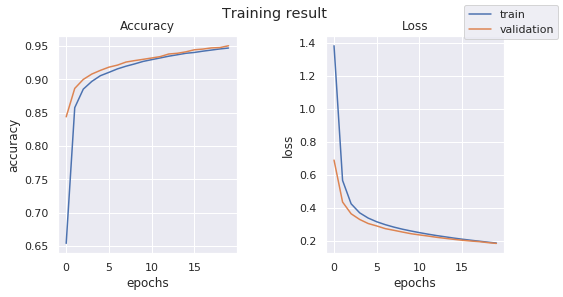

In [0]:
display_history(history = history)

In [0]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :',acc)

Accuracy : 0.9459


In [0]:
if model != None:
  K.clear_session()
model = create_mlp(4)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 1.6222 - acc: 0.5840 - val_loss: 0.7722 - val_acc: 0.8164
Epoch 2/20
 - 2s - loss: 0.5809 - acc: 0.8438 - val_loss: 0.4220 - val_acc: 0.8877
Epoch 3/20
 - 2s - loss: 0.4056 - acc: 0.8868 - val_loss: 0.3489 - val_acc: 0.9037
Epoch 4/20
 - 2s - loss: 0.3464 - acc: 0.9001 - val_loss: 0.3065 - val_acc: 0.9148
Epoch 5/20
 - 2s - loss: 0.3127 - acc: 0.9097 - val_loss: 0.2843 - val_acc: 0.9214
Epoch 6/20
 - 2s - loss: 0.2897 - acc: 0.9164 - val_loss: 0.2676 - val_acc: 0.9242
Epoch 7/20
 - 2s - loss: 0.2712 - acc: 0.9214 - val_loss: 0.2509 - val_acc: 0.9298
Epoch 8/20
 - 2s - loss: 0.2552 - acc: 0.9256 - val_loss: 0.2402 - val_acc: 0.9333
Epoch 9/20
 - 2s - loss: 0.2414 - acc: 0.9296 - val_loss: 0.2313 - val_acc: 0.9338
Epoch 10/20
 - 2s - loss: 0.2295 - acc: 0.9326 - val_loss: 0.2212 - val_acc: 0.9372
Epoch 11/20
 - 2s - loss: 0.2184 - acc: 0.9362 - val_loss: 0.2134 - val_acc: 0.9401
Epoch 12/20
 - 2s - loss: 0.2093 - 

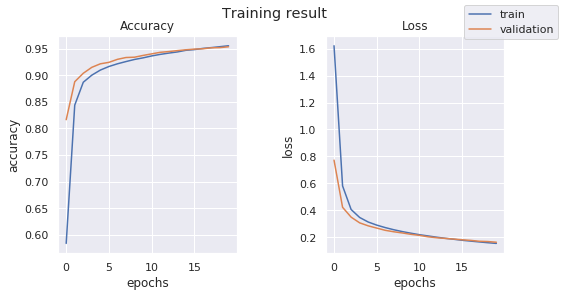

In [0]:
display_history(history = history)

In [0]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9514


In [0]:
if model != None:
  K.clear_session()
model = create_mlp(20)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

In [0]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 4s - loss: 2.3013 - acc: 0.1137 - val_loss: 2.3009 - val_acc: 0.1060
Epoch 2/20
 - 4s - loss: 2.2990 - acc: 0.1140 - val_loss: 2.2979 - val_acc: 0.1060
Epoch 3/20
 - 4s - loss: 2.2927 - acc: 0.1140 - val_loss: 2.2871 - val_acc: 0.1061
Epoch 4/20
 - 4s - loss: 2.2653 - acc: 0.2078 - val_loss: 2.2264 - val_acc: 0.2019
Epoch 5/20
 - 4s - loss: 2.0684 - acc: 0.2119 - val_loss: 1.8803 - val_acc: 0.2183
Epoch 6/20
 - 4s - loss: 1.6935 - acc: 0.3222 - val_loss: 1.9131 - val_acc: 0.2010
Epoch 7/20
 - 4s - loss: 1.3936 - acc: 0.4586 - val_loss: 1.1585 - val_acc: 0.6030
Epoch 8/20
 - 4s - loss: 1.1299 - acc: 0.5883 - val_loss: 0.9250 - val_acc: 0.6647
Epoch 9/20
 - 4s - loss: 0.8561 - acc: 0.7094 - val_loss: 0.6728 - val_acc: 0.7899
Epoch 10/20
 - 4s - loss: 0.5688 - acc: 0.8236 - val_loss: 0.4417 - val_acc: 0.8769
Epoch 11/20
 - 4s - loss: 0.4444 - acc: 0.8694 - val_loss: 0.3500 - val_acc: 0.9072
Epoch 12/20
 - 4s - loss: 0.3373 - 

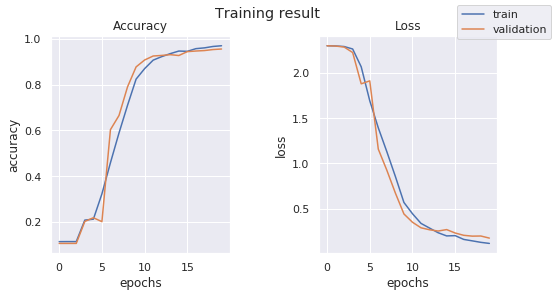

In [0]:
display_history(history = history)

In [0]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9531


## Weight initializer
- he_uniform
- he_normal
- glorot_normal   
cf) The default initializer is glorot_uniform, so it's not measured

In [0]:
def create_mlp(layers, initializer):
  model = Sequential()
  model.add(Dense(HIDDENS, input_shape = (784,), activation = 'relu', kernel_initializer = initializer))
  if layers > 2:
    for i in range(layers - 2):
      model.add(Dense(HIDDENS, activation = 'relu',kernel_initializer=initializer))
  model.add(Dense(CLASSES, activation = 'softmax', kernel_initializer = initializer))
  return model

In [0]:
if model != None:
  K.clear_session()
model = create_mlp(4, 'he_uniform')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 1.0654 - acc: 0.7062 - val_loss: 0.4739 - val_acc: 0.8710
Epoch 2/20
 - 2s - loss: 0.4227 - acc: 0.8808 - val_loss: 0.3410 - val_acc: 0.9009
Epoch 3/20
 - 2s - loss: 0.3324 - acc: 0.9050 - val_loss: 0.2872 - val_acc: 0.9159
Epoch 4/20
 - 2s - loss: 0.2893 - acc: 0.9172 - val_loss: 0.2607 - val_acc: 0.9222
Epoch 5/20
 - 2s - loss: 0.2605 - acc: 0.9247 - val_loss: 0.2384 - val_acc: 0.9296
Epoch 6/20
 - 2s - loss: 0.2392 - acc: 0.9306 - val_loss: 0.2265 - val_acc: 0.9318
Epoch 7/20
 - 2s - loss: 0.2223 - acc: 0.9363 - val_loss: 0.2096 - val_acc: 0.9392
Epoch 8/20
 - 2s - loss: 0.2074 - acc: 0.9395 - val_loss: 0.1999 - val_acc: 0.9420
Epoch 9/20
 - 2s - loss: 0.1949 - acc: 0.9438 - val_loss: 0.1893 - val_acc: 0.9456
Epoch 10/20
 - 2s - loss: 0.1838 - acc: 0.9469 - val_loss: 0.1813 - val_acc: 0.9471
Epoch 11/20
 - 2s - loss: 0.1742 - acc: 0.9495 - val_loss: 0.1723 - val_acc: 0.9494
Epoch 12/20
 - 2s - loss: 0.1656 - 

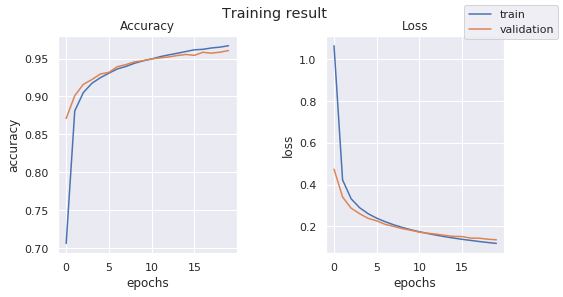

In [0]:
display_history(history = history)

In [0]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9611


In [0]:
if model != None:
  K.clear_session()
model = create_mlp(4,'he_normal')
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 1.1823 - acc: 0.6810 - val_loss: 0.5012 - val_acc: 0.8703
Epoch 2/20
 - 2s - loss: 0.4353 - acc: 0.8791 - val_loss: 0.3468 - val_acc: 0.9047
Epoch 3/20
 - 2s - loss: 0.3429 - acc: 0.9013 - val_loss: 0.3017 - val_acc: 0.9118
Epoch 4/20
 - 2s - loss: 0.3010 - acc: 0.9126 - val_loss: 0.2686 - val_acc: 0.9237
Epoch 5/20
 - 2s - loss: 0.2724 - acc: 0.9215 - val_loss: 0.2482 - val_acc: 0.9293
Epoch 6/20
 - 2s - loss: 0.2510 - acc: 0.9269 - val_loss: 0.2300 - val_acc: 0.9356
Epoch 7/20
 - 2s - loss: 0.2328 - acc: 0.9325 - val_loss: 0.2169 - val_acc: 0.9384
Epoch 8/20
 - 2s - loss: 0.2188 - acc: 0.9366 - val_loss: 0.2057 - val_acc: 0.9425
Epoch 9/20
 - 2s - loss: 0.2053 - acc: 0.9404 - val_loss: 0.1965 - val_acc: 0.9447
Epoch 10/20
 - 2s - loss: 0.1951 - acc: 0.9435 - val_loss: 0.1918 - val_acc: 0.9440
Epoch 11/20
 - 2s - loss: 0.1848 - acc: 0.9467 - val_loss: 0.1818 - val_acc: 0.9495
Epoch 12/20
 - 2s - loss: 0.1762 - 

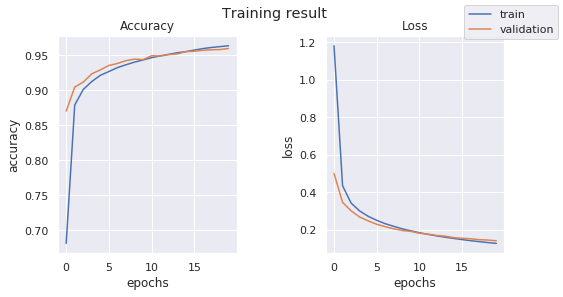

In [0]:
display_history(history = history)

In [0]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9573


In [0]:
if model != None:
  K.clear_session()
model = create_mlp(4, 'glorot_normal')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 1.4986 - acc: 0.6196 - val_loss: 0.7111 - val_acc: 0.8280
Epoch 2/20
 - 2s - loss: 0.5510 - acc: 0.8558 - val_loss: 0.4204 - val_acc: 0.8847
Epoch 3/20
 - 2s - loss: 0.4043 - acc: 0.8854 - val_loss: 0.3507 - val_acc: 0.9000
Epoch 4/20
 - 2s - loss: 0.3524 - acc: 0.8990 - val_loss: 0.3119 - val_acc: 0.9112
Epoch 5/20
 - 2s - loss: 0.3209 - acc: 0.9077 - val_loss: 0.2882 - val_acc: 0.9170
Epoch 6/20
 - 2s - loss: 0.2980 - acc: 0.9140 - val_loss: 0.2718 - val_acc: 0.9214
Epoch 7/20
 - 2s - loss: 0.2797 - acc: 0.9191 - val_loss: 0.2563 - val_acc: 0.9281
Epoch 8/20
 - 2s - loss: 0.2636 - acc: 0.9242 - val_loss: 0.2465 - val_acc: 0.9292
Epoch 9/20
 - 2s - loss: 0.2500 - acc: 0.9279 - val_loss: 0.2324 - val_acc: 0.9333
Epoch 10/20
 - 2s - loss: 0.2378 - acc: 0.9313 - val_loss: 0.2267 - val_acc: 0.9356
Epoch 11/20
 - 2s - loss: 0.2268 - acc: 0.9348 - val_loss: 0.2152 - val_acc: 0.9380
Epoch 12/20
 - 2s - loss: 0.2164 - 

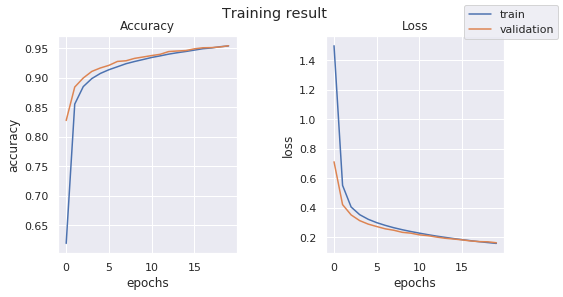

In [0]:
display_history(history = history)

In [0]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9526


## Optimizer
- rmsprop
- adam  
cf) sgd is already measured.

In [0]:
if model != None:
  K.clear_session()
model = create_mlp(4,'glorot_normal')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 2s - loss: 0.3709 - acc: 0.8875 - val_loss: 0.2023 - val_acc: 0.9408
Epoch 2/20
 - 2s - loss: 0.1706 - acc: 0.9481 - val_loss: 0.1433 - val_acc: 0.9586
Epoch 3/20
 - 2s - loss: 0.1204 - acc: 0.9635 - val_loss: 0.1354 - val_acc: 0.9591
Epoch 4/20
 - 2s - loss: 0.0930 - acc: 0.9720 - val_loss: 0.1069 - val_acc: 0.9698
Epoch 5/20
 - 2s - loss: 0.0764 - acc: 0.9772 - val_loss: 0.1140 - val_acc: 0.9693
Epoch 6/20
 - 2s - loss: 0.0653 - acc: 0.9800 - val_loss: 0.1167 - val_acc: 0.9700
Epoch 7/20
 - 2s - loss: 0.0569 - acc: 0.9822 - val_loss: 0.1206 - val_acc: 0.9708
Epoch 8/20
 - 2s - loss: 0.0480 - acc: 0.9853 - val_loss: 0.1099 - val_acc: 0.9733
Epoch 9/20
 - 2s - loss: 0.0439 - acc: 0.9871 - val_loss: 0.1169 - val_acc: 0.9734
Epoch 10/20
 - 2s - loss: 0.0389 - acc: 0.9884 - val_loss: 0.1291 - val_acc: 0.9714
Epoch 11/20
 - 2s - loss: 0.0373 - acc: 0.9890 - val_loss: 0.1477 - val_acc: 0.9677
Epoch 12/20
 - 2s - loss: 0.0301 - 

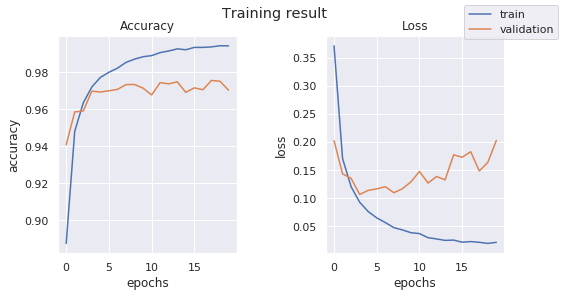

In [0]:
display_history(history = history)

In [0]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9723


In [0]:
if model != None:
  K.clear_session()
model = create_mlp(4,'glorot_normal')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 3s - loss: 0.3447 - acc: 0.9008 - val_loss: 0.1452 - val_acc: 0.9583
Epoch 2/20
 - 2s - loss: 0.1285 - acc: 0.9610 - val_loss: 0.1224 - val_acc: 0.9617
Epoch 3/20
 - 2s - loss: 0.0869 - acc: 0.9735 - val_loss: 0.1054 - val_acc: 0.9687
Epoch 4/20
 - 2s - loss: 0.0649 - acc: 0.9794 - val_loss: 0.1028 - val_acc: 0.9693
Epoch 5/20
 - 2s - loss: 0.0506 - acc: 0.9845 - val_loss: 0.1199 - val_acc: 0.9664
Epoch 6/20
 - 2s - loss: 0.0398 - acc: 0.9869 - val_loss: 0.0929 - val_acc: 0.9735
Epoch 7/20
 - 2s - loss: 0.0340 - acc: 0.9892 - val_loss: 0.0933 - val_acc: 0.9741
Epoch 8/20
 - 2s - loss: 0.0269 - acc: 0.9916 - val_loss: 0.0987 - val_acc: 0.9755
Epoch 9/20
 - 2s - loss: 0.0231 - acc: 0.9922 - val_loss: 0.1121 - val_acc: 0.9733
Epoch 10/20
 - 2s - loss: 0.0229 - acc: 0.9921 - val_loss: 0.0974 - val_acc: 0.9757
Epoch 11/20
 - 2s - loss: 0.0164 - acc: 0.9947 - val_loss: 0.1144 - val_acc: 0.9732
Epoch 12/20
 - 2s - loss: 0.0145 - 

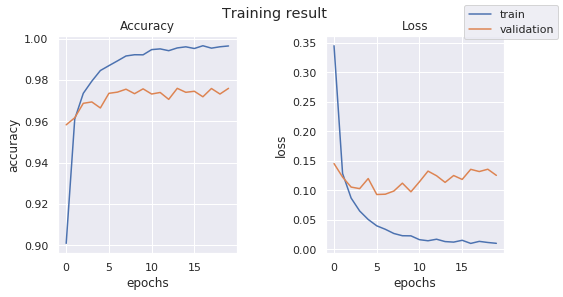

In [0]:
display_history(history = history)

In [0]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9774


In [0]:
from keras.regularizers import l2

def create_mlp(layers, initializer):

  model = Sequential()
  model.add(Dense(HIDDENS, input_shape = (784,), activation = 'relu', kernel_initializer = initializer,kernel_regularizer=l2(0.01)))
  if layers > 2:
    for i in range(layers - 2):
      model.add(Dense(HIDDENS, activation = 'relu',kernel_initializer=initializer))
  model.add(Dense(CLASSES, activation = 'softmax', kernel_initializer = initializer))
  return model

In [0]:
if model != None:
  K.clear_session()
model = create_mlp(4, 'glorot_normal')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 3s - loss: 0.7785 - acc: 0.8942 - val_loss: 0.3151 - val_acc: 0.9473
Epoch 2/20
 - 2s - loss: 0.2860 - acc: 0.9470 - val_loss: 0.2831 - val_acc: 0.9449
Epoch 3/20
 - 2s - loss: 0.2393 - acc: 0.9554 - val_loss: 0.2230 - val_acc: 0.9621
Epoch 4/20
 - 2s - loss: 0.2255 - acc: 0.9593 - val_loss: 0.2322 - val_acc: 0.9564
Epoch 5/20
 - 2s - loss: 0.2062 - acc: 0.9642 - val_loss: 0.2113 - val_acc: 0.9620
Epoch 6/20
 - 2s - loss: 0.2009 - acc: 0.9642 - val_loss: 0.2050 - val_acc: 0.9663
Epoch 7/20
 - 2s - loss: 0.1915 - acc: 0.9670 - val_loss: 0.2325 - val_acc: 0.9557
Epoch 8/20
 - 2s - loss: 0.1894 - acc: 0.9676 - val_loss: 0.1992 - val_acc: 0.9647
Epoch 9/20
 - 2s - loss: 0.1765 - acc: 0.9704 - val_loss: 0.1895 - val_acc: 0.9649
Epoch 10/20
 - 2s - loss: 0.1743 - acc: 0.9704 - val_loss: 0.1954 - val_acc: 0.9671
Epoch 11/20
 - 2s - loss: 0.1753 - acc: 0.9706 - val_loss: 0.1822 - val_acc: 0.9683
Epoch 12/20
 - 2s - loss: 0.1685 - 

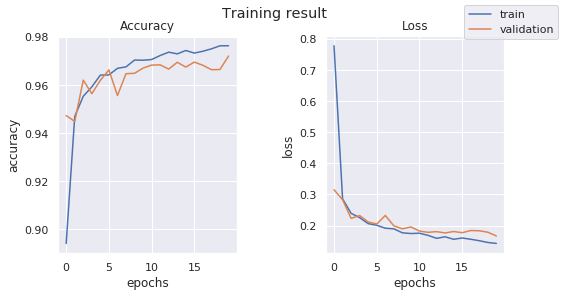

In [0]:
display_history(history = history)

In [0]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9738


## Regularization
- L2
- Dropout
- Batch normalization

In [0]:
from keras.regularizers import l2

def create_mlp(layers, initializer):

  model = Sequential()
  model.add(Dense(HIDDENS, input_shape = (784,), activation = 'relu', kernel_initializer = initializer, kernel_regularizer = l2(0.01)))
  if layers > 2:
    for i in range(layers - 2):
      model.add(Dense(HIDDENS, activation = 'relu',kernel_initializer=initializer))
  model.add(Dense(CLASSES, activation = 'softmax', kernel_initializer = initializer))
  return model

In [0]:
if model != None:
  K.clear_session()
model = create_mlp(4,'glorot_normal')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 3s - loss: 0.7782 - acc: 0.8922 - val_loss: 0.3026 - val_acc: 0.9496
Epoch 2/20
 - 2s - loss: 0.2783 - acc: 0.9482 - val_loss: 0.2339 - val_acc: 0.9594
Epoch 3/20
 - 2s - loss: 0.2381 - acc: 0.9552 - val_loss: 0.2244 - val_acc: 0.9611
Epoch 4/20
 - 2s - loss: 0.2190 - acc: 0.9609 - val_loss: 0.2365 - val_acc: 0.9539
Epoch 5/20
 - 2s - loss: 0.2049 - acc: 0.9640 - val_loss: 0.2070 - val_acc: 0.9639
Epoch 6/20
 - 2s - loss: 0.1991 - acc: 0.9652 - val_loss: 0.1970 - val_acc: 0.9653
Epoch 7/20
 - 2s - loss: 0.1871 - acc: 0.9679 - val_loss: 0.1936 - val_acc: 0.9649
Epoch 8/20
 - 2s - loss: 0.1835 - acc: 0.9686 - val_loss: 0.2001 - val_acc: 0.9631
Epoch 9/20
 - 2s - loss: 0.1744 - acc: 0.9703 - val_loss: 0.1797 - val_acc: 0.9687
Epoch 10/20
 - 2s - loss: 0.1733 - acc: 0.9704 - val_loss: 0.1940 - val_acc: 0.9664
Epoch 11/20
 - 2s - loss: 0.1676 - acc: 0.9720 - val_loss: 0.1747 - val_acc: 0.9706
Epoch 12/20
 - 2s - loss: 0.1659 - 

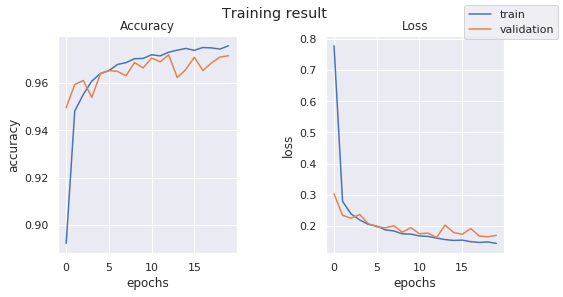

In [0]:
display_history(history = history)

In [0]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9688


In [0]:
from keras.layers.core import Dropout

def create_mlp(layers, initializer):

  model = Sequential()
  model.add(Dense(HIDDENS, input_shape = (784,), activation = 'relu', kernel_initializer = initializer))
  model.add(Dropout(0.3))
  if layers > 2:
    for i in range(layers - 2):
      model.add(Dense(HIDDENS, activation = 'relu',kernel_initializer=initializer))
  model.add(Dense(CLASSES, activation = 'softmax', kernel_initializer = initializer))
  return model

In [0]:
if model != None:
  K.clear_session()
model = create_mlp(4,'glorot_normal')
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________

In [0]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 3s - loss: 0.4373 - acc: 0.8664 - val_loss: 0.1627 - val_acc: 0.9530
Epoch 2/20
 - 3s - loss: 0.1870 - acc: 0.9432 - val_loss: 0.1224 - val_acc: 0.9626
Epoch 3/20
 - 2s - loss: 0.1438 - acc: 0.9561 - val_loss: 0.1071 - val_acc: 0.9667
Epoch 4/20
 - 2s - loss: 0.1224 - acc: 0.9632 - val_loss: 0.0962 - val_acc: 0.9719
Epoch 5/20
 - 3s - loss: 0.1078 - acc: 0.9654 - val_loss: 0.0951 - val_acc: 0.9722
Epoch 6/20
 - 3s - loss: 0.0948 - acc: 0.9704 - val_loss: 0.0872 - val_acc: 0.9748
Epoch 7/20
 - 3s - loss: 0.0842 - acc: 0.9731 - val_loss: 0.0926 - val_acc: 0.9731
Epoch 8/20
 - 2s - loss: 0.0814 - acc: 0.9735 - val_loss: 0.0846 - val_acc: 0.9767
Epoch 9/20
 - 2s - loss: 0.0743 - acc: 0.9752 - val_loss: 0.0875 - val_acc: 0.9746
Epoch 10/20
 - 2s - loss: 0.0679 - acc: 0.9775 - val_loss: 0.0881 - val_acc: 0.9739
Epoch 11/20
 - 2s - loss: 0.0644 - acc: 0.9789 - val_loss: 0.0832 - val_acc: 0.9768
Epoch 12/20
 - 2s - loss: 0.0641 - 

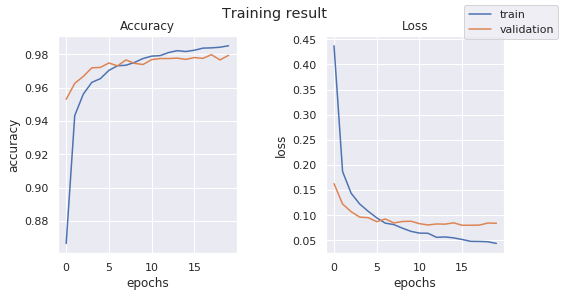

In [0]:
display_history(history = history)

In [0]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.9789


In [0]:
from keras.layers import Activation, BatchNormalization
def create_mlp(layers, initializer):

  model = Sequential()
  model.add(Dense(HIDDENS, input_shape = (784,), kernel_initializer = initializer))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  if layers > 2:
    for i in range(layers - 2):
      model.add(Dense(HIDDENS, activation = 'relu',kernel_initializer=initializer))
  model.add(Dense(CLASSES, activation = 'softmax', kernel_initializer = initializer))
  return model

In [0]:
if model != None:
  K.clear_session()
model = create_mlp(4,'glorot_uniform')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 135,306
Trainable params: 135,050
Non-trainable params: 256
______________________________________________

In [0]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics= ['accuracy'])

timer = Timer()
timer.start_timer()
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS,
                    verbose = VERBOSE, validation_split = VALIDATION_SPLIT)
elasped = timer.stop_timer()
print('Elasped time(HH:MM:SS.ms) - {}'.format(elasped))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
 - 3s - loss: 0.2826 - acc: 0.9174 - val_loss: 0.1387 - val_acc: 0.9596
Epoch 2/20
 - 2s - loss: 0.1061 - acc: 0.9675 - val_loss: 0.1075 - val_acc: 0.9680
Epoch 3/20
 - 3s - loss: 0.0720 - acc: 0.9768 - val_loss: 0.0979 - val_acc: 0.9716
Epoch 4/20
 - 3s - loss: 0.0499 - acc: 0.9848 - val_loss: 0.0911 - val_acc: 0.9738
Epoch 5/20
 - 3s - loss: 0.0405 - acc: 0.9866 - val_loss: 0.1030 - val_acc: 0.9696
Epoch 6/20
 - 3s - loss: 0.0308 - acc: 0.9895 - val_loss: 0.0903 - val_acc: 0.9746
Epoch 7/20
 - 3s - loss: 0.0296 - acc: 0.9899 - val_loss: 0.0913 - val_acc: 0.9742
Epoch 8/20
 - 3s - loss: 0.0214 - acc: 0.9932 - val_loss: 0.1145 - val_acc: 0.9708
Epoch 9/20
 - 3s - loss: 0.0200 - acc: 0.9932 - val_loss: 0.1034 - val_acc: 0.9742
Epoch 10/20
 - 3s - loss: 0.0185 - acc: 0.9934 - val_loss: 0.1100 - val_acc: 0.9738
Epoch 11/20
 - 2s - loss: 0.0159 - acc: 0.9946 - val_loss: 0.1031 - val_acc: 0.9777
Epoch 12/20
 - 2s - loss: 0.0162 - 

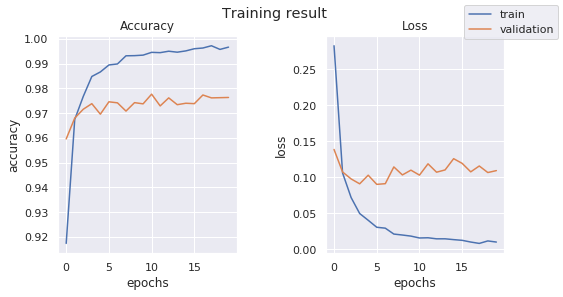

In [0]:
display_history(history = history)

In [0]:
_, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Accuracy :', acc)

Accuracy : 0.977
